# Steps in Mission Processing

In [45]:
import cftime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from PyAstronomy import pyaC
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
mission_nc_path = '../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission_dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: DUNEX microSWIFT drifter - Mission 19
    institution: University of Washington - Applied Physics Lab
    source: Observations from microSWIFT drifters deployed in the DUring Nearshore Events eXperiment (DUNEX)
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    creator_country: USA
    creator_email: erainvil@uw.edu
    creator_name: EJ Rainville, Jim Thomson, Melissa Moulton, and Morteza Derakhti at University of Washington - Applied Physics Lab
    creator_phone: (303) 653-1226
    creator_sector: academic
    creator_state: Washington
    featureType: trajectory
    cdm_data_type: Trajectory
    platform: microSWIFT wave buoy
    publisher_country: USA
    publisher_email: frfwebmaster@usace.army.mil
    publisher_name: USACE/CHL/COAB
    history: 2022-12-28 23:19:30.831831 Python
    references: https://github.com/SASlabgroup/microSWIFT and http

<AxesSubplot: xlabel='Cross Shore Location [meters]', ylabel='Along Shore Location [meters]'>

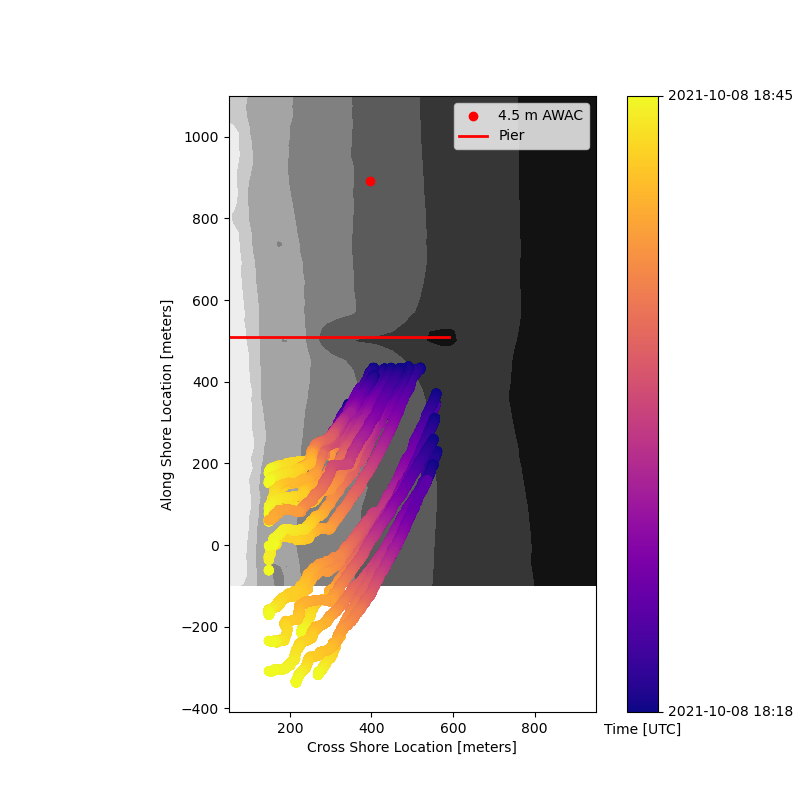

In [3]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
mission_tools.plot_mission_tracks(mission_dataset, bathy_file)

In [4]:
# Define a colormap so each microSWIFT gets a different color
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

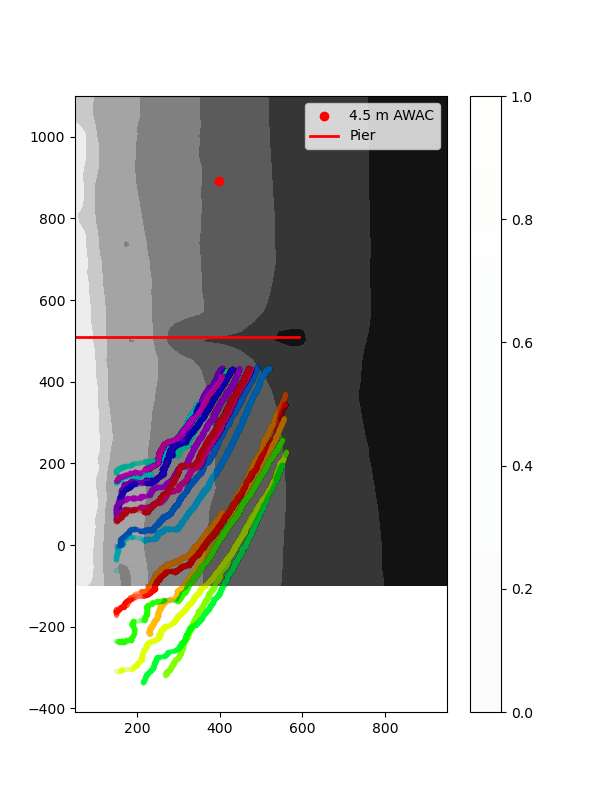

In [21]:
bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

fig, ax = plt.subplots(figsize=(6,8))

ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')
bathy_dataset.close()

awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                        # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
            color='r', label='4.5 m AWAC')

ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier')

cmap = get_cmap(mission_dataset['trajectory'][:].size)
colors = []
for n in range(0, mission_dataset['trajectory'][:].size):
    im = ax.scatter(mission_dataset['xFRF'][n,:], mission_dataset['yFRF'][n,:],
                    marker='.', alpha=0.01, color=cmap(n))
    colors.append(cmap(n))

cbar = fig.colorbar(im, ax=ax)

ax.legend()

Text(0, 0.5, 'Sea Surface Elevation [m]')

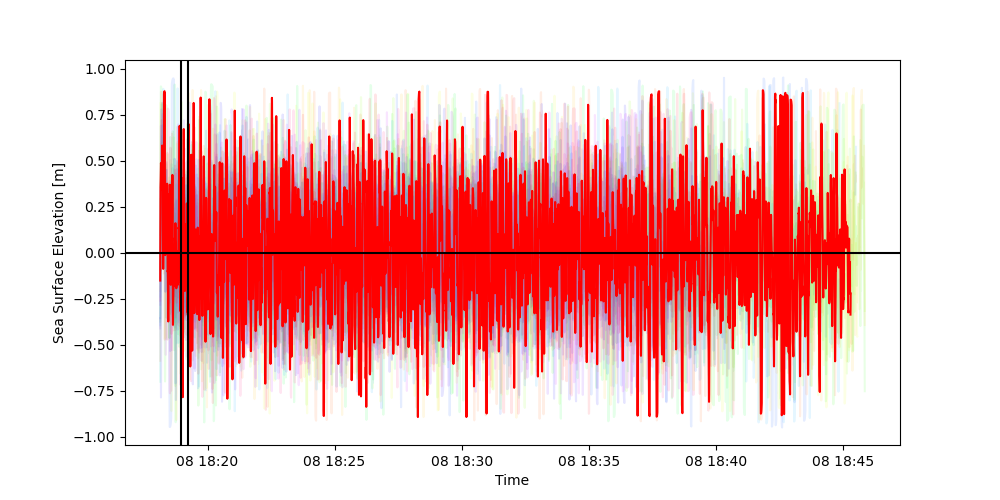

In [55]:
slice_start = 700
slice_end = 900

fig, ax = plt.subplots(figsize=(10,5))
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
for n in range(1, mission_dataset['trajectory'][:].size):
    ax.plot(time,
            mission_dataset['sea_surface_elevation'][n,:], 
            color=colors[n], alpha=0.1)

ax.plot(time, mission_dataset['sea_surface_elevation'][0,:], color=colors[0])
ax.axhline(y=0, color='k')
ax.axvline(x=time[slice_start], color='k', linestyle='dashed')
ax.axvline(x=time[slice_end], color='k', linestyle='dashed')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m]')

Text(0, 0.5, 'Sea Surface Elevation [m]')

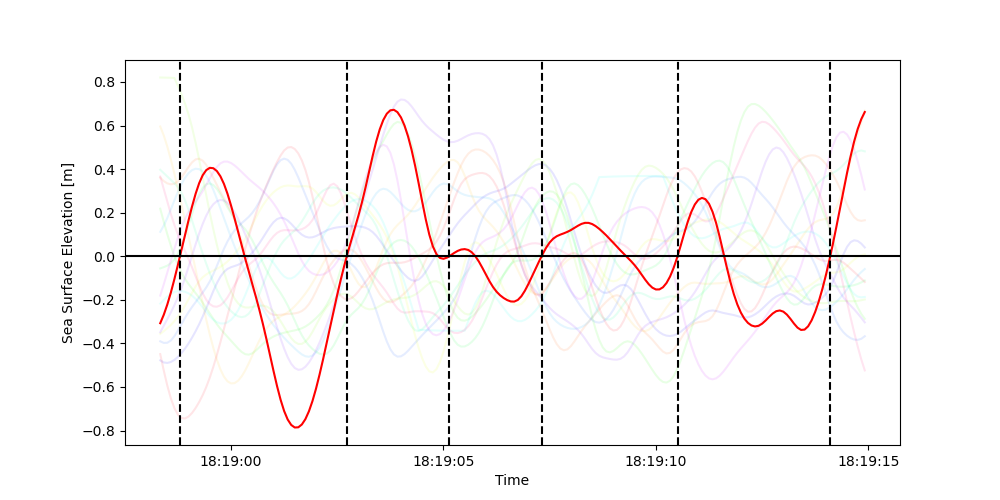

In [53]:
fig, ax = plt.subplots(figsize=(10,5))

for n in range(1, mission_dataset['trajectory'][:].size):
    ax.plot(time[slice_start:slice_end],
            mission_dataset['sea_surface_elevation'][n,slice_start:slice_end], 
            color=colors[n], alpha=0.1)

eta_example = mission_dataset['sea_surface_elevation'][0,slice_start:slice_end]
time_example = time[slice_start:slice_end]

ax.plot(time_example, eta_example, color=colors[0], alpha=1)

cross_time, \
cross_ind = pyaC.zerocross1d(mission_dataset['time'][slice_start:slice_end],
                                          eta_example, getIndices=True)
wave_times = cross_time[::2]
wave_datetimes = cftime.num2pydate(wave_times,
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
for n in range(len(wave_datetimes)):
    ax.axvline(wave_datetimes[n], color='k', linestyle='dashed')

ax.axhline(y=0, color='k')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m]')

## Compute individual waves for each microSWIFT

In [7]:
wave_heights_each_micro = []
wave_x_locs_each_micro = []
wave_y_locs_each_micro = []
for n in range(mission_dataset['trajectory'][:].size):
    x_locations = mission_dataset['xFRF'][n,:]
    y_locations = mission_dataset['yFRF'][n,:]
    eta = mission_dataset['sea_surface_elevation'][n,:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file,
                                                        single_trajectory=True)
    wave_heights_each_micro.append(wave_heights)
    wave_x_locs_each_micro.append(wave_x_locs)
    wave_y_locs_each_micro.append(wave_y_locs)

## Plot a stacked histogram of the wave height from each micro

/var/folders/tj/6lfp4z413tg03k2fzx57134c0000gn/T/ipykernel_30001/3027310003.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ax.hist(np.array(wave_heights_each_micro), bins=30,


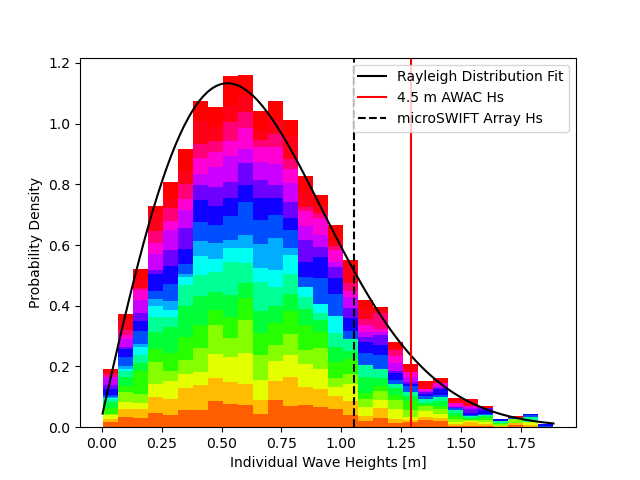

In [20]:
fig, ax = plt.subplots()
ax.hist(np.array(wave_heights_each_micro), bins=30,
                  stacked=True, density=True, color=colors)
wave_heights_flat = np.concatenate(wave_heights_each_micro).flatten()
loc, scale = stats.rayleigh.fit(wave_heights_flat)
rayleigh_dist_x = np.linspace(min(wave_heights_flat),
                              max(wave_heights_flat),
                              100)
ax.plot(rayleigh_dist_x,
            stats.rayleigh(scale=scale, loc=loc).pdf(rayleigh_dist_x),
            label="Rayleigh Distribution Fit", color='k')

sig_wave_height_top_third = mission_tools.compute_sig_wave_height_top_third(wave_heights)
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
mission_time = np.median(mission_dataset['time'][:])
awac_sig_wave_height = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)

ax.axvline(x=awac_sig_wave_height, label='4.5 m AWAC Hs', color='r')
ax.axvline(x=sig_wave_height_top_third, label='microSWIFT Array Hs', color='k', linestyle='dashed')
ax.set_xlabel('Individual Wave Heights [m]')
ax.set_ylabel('Probability Density')
ax.legend()


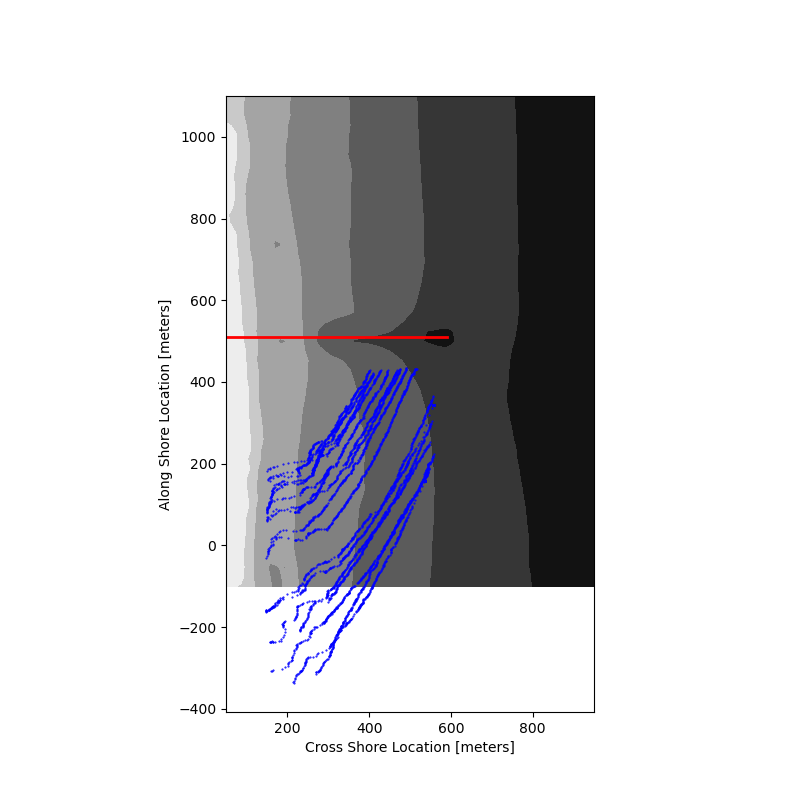

In [9]:
x_locations = mission_dataset['xFRF'][:]
y_locations = mission_dataset['yFRF'][:]
eta = mission_dataset['sea_surface_elevation'][:]
time = mission_dataset['time'][:]

wave_heights, \
wave_x_locs, \
wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                     y_locations,
                                                     eta, time,
                                                     bathy_file)

mission_tools.plot_wave_locations(wave_x_locs, wave_y_locs, bathy_file, 'b')

Hs = 1.2114796319654946 meters - 4 * sqrt(var(eta))
Hs = 1.0550006610907576 meters - Average Top Third Method
Hs = 1.0584839288897807 meters - 1.416 * H_rms


/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


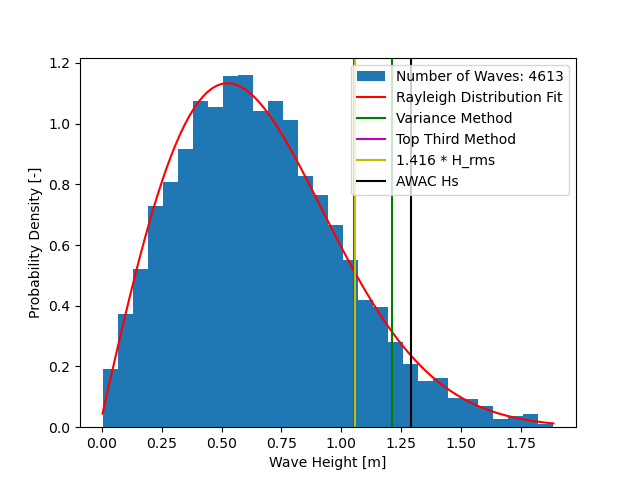

In [10]:
num_bins = 30
ax = mission_tools.plot_wave_height_dist(wave_heights, num_bins)

sig_wave_height_var = mission_tools.compute_sig_wave_height_var(eta)
print(f'Hs = {sig_wave_height_var} meters - 4 * sqrt(var(eta))')

sig_wave_height_top_third = mission_tools.compute_sig_wave_height_top_third(wave_heights)
print(f'Hs = {sig_wave_height_top_third} meters - Average Top Third Method')

sig_wave_height_rms = mission_tools.compute_sig_wave_height_rms(wave_heights)
print(f'Hs = {sig_wave_height_rms} meters - 1.416 * H_rms')

awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
mission_time = np.median(mission_dataset['time'][:])
awac_sig_wave_height = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)

ax.axvline(x=sig_wave_height_var, label='Variance Method', color='g')
ax.axvline(x=sig_wave_height_top_third, label='Top Third Method', color='m')
ax.axvline(x=sig_wave_height_rms, label='1.416 * H_rms', color='y')
ax.axvline(x=awac_sig_wave_height, label='AWAC Hs', color='k')
ax.legend()